# Fiber Learning Model Demo

This notebook demonstrates fiber learning with generative models on small FIFs trained on EMNIST.<br>
First we train a subject model from which we want to learn the fibers from.<br>
Next we train a dimension-reducing VAE that should be lossless and provide a more dense latent space in which the fiber learning model is operating.<br>
Lastly we train the fiber learning model on the resulting representations of the subject model in the latent space of the VAE.

In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import lightning_trainable
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import pickle as pkl
from pathlib import Path
import shutil
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
matplotlib.rcParams.update({'font.size': 20})

INFO: Using pytorch backend


In [2]:
save = True
plot_dir = "demo_2m"
if save:
    Path(f"plots/{plot_dir}").mkdir(parents=True, exist_ok=True)

## Subject Model

First we train a small FIF with 5-dimensional bottleneck on the digit split of EMNIST.

In [3]:
hparams_sm_fif = fff.fif.FreeFormInjectiveFlowHParams(
    noise= 0.1,
    data_set= {"name": "2moons"},
    loss_weights= {"noisy_reconstruction": 10, "nll": 1},
    train_models= True,
    models= [
        {"name": "fff.model.ResNet",
         "latent_dim": 1,
         "layers_spec": [
             [256,256],
             [256,256],
         ]}
    ],
    optimizer= {
        "name": "adam",
        "lr": 0.001,
        "weight_decay": 0.01,
    },
    lr_scheduler= "onecyclelr",
    max_epochs= 25,
    batch_size= 128)

In [4]:
subject_model = fff.fif.FreeFormInjectiveFlow(hparams_sm_fif)

2moons
cond_dim:  0
latent_dim:  1


In [5]:
subject_model.fit(logger_kwargs=dict(name="sm_fif_2m", save_dir="lightning_logs"))
# monitor the training metric with "tensorboard --logdir lightning_logs"

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
INFO: 
  | Name   | Type       | Params
--------------------------------------
0 | models | Sequential | 268 K 
--------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.073     Total estimate

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/export/home/wjoran/FFF/fff/base.py:674: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = torch.mean(torch.abs(torch.std(z_details, dim=0) - 1))


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO: `Trainer.fit` stopped: `max_epochs=25` reached.


{'training/z 1D-Wasserstein-1': 0.2425464391708374,
 'training/z std': 0.9078072309494019,
 'training/loss': 1.1563220024108887,
 'training/nll': 0.2625129520893097,
 'training/reconstruction': 0.09749886393547058,
 'training/noisy_reconstruction': 0.0893809124827385,
 'training/sqr_reconstruction': 0.013070458546280861,
 'validation/z 1D-Wasserstein-1': 0.1395023763179779,
 'validation/z std': nan,
 'validation/loss': 3.3811817169189453,
 'validation/nll': 2.3654918670654297,
 'validation/vol_change_encoder': -0.7968835234642029,
 'validation/vol_change_decoder': -0.9437301158905029,
 'validation/nll_encoder': 2.2186455726623535,
 'validation/nll_decoder': 2.3654918670654297,
 'validation/reconstruction': 0.10592896491289139,
 'validation/noisy_reconstruction': 0.10156899690628052,
 'validation/sqr_reconstruction': 0.01948920078575611,
 'validation/masked_reconstruction': 0.10156899690628052,
 'validation/z_reconstruction_encoder': 0.006549175828695297,
 'validation/fiber_loss': nan,


In [6]:
sm_path = "lightning_logs/sm_fif_2m/version_0" # Check at which version the subject_model is saved!!!!

In [5]:
#If already trained:
subject_model = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(sm_path + "/checkpoints/last.ckpt")

2moons
cond_dim:  0
latent_dim:  1


In [7]:
torch.set_grad_enabled(False)

In [8]:
from fff.evaluate.plots import all_conditions
def plot_manifold(rectangular_flow, condition=None):
    fig, ax = plt.subplots(figsize=[16,11])
    data = {}

    train_batch = rectangular_flow.train_data[:]
    conditioned = rectangular_flow.apply_conditions(train_batch)
    train_samples = conditioned.x_noisy
    c = conditioned.condition
    c_empt = torch.empty((c.shape[0], 0), dtype=c.dtype)
    device = rectangular_flow.device
    #print(train_samples.shape)

    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_empt.split(batch_size))
    ])    
    x1_train = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_train.split(batch_size), c_empt.split(batch_size))
    ])
    print(z_train.shape[0])

    sc = ax.scatter(*train_samples.T, s=3, label="Original", c=z_train.numpy(), cmap='prism')
    ax.scatter(*x1_train.cpu().T, s=15, label="Reconstruction", c=z_train.numpy(), cmap='prism')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.axis('equal')
    
    cbar = fig.colorbar(sc)
    cbar.set_label('latent space', rotation=270, labelpad=10, y=0.6)
    path = f"plots/{plot_dir}/Mapping.png"
    #Path(f"plots/2m/sm").mkdir(parents=True, exist_ok=True)
    ax.set_xlim(-2.15, 2.15)
    ax.set_ylim(-1.9, 1.9)
    if save:
        plt.savefig(path, bbox_inches='tight')
    #plt.scatter(*x1_test.T, s=2, label="Samples")
    #print(x1_test[0])

    plt.show()
    plt.close()

    
    
    a = np.linspace(-3,3,100)
    plt.hist(z_train.squeeze(), bins=100, density=True)
    plt.plot(a, normal(a), linewidth=4)
    plt.xlabel("AE-embedding")
    plt.ylabel("density")
    plt.tight_layout()
    path = f"plots/2m/sm/LD.png"

In [9]:
def normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

60000


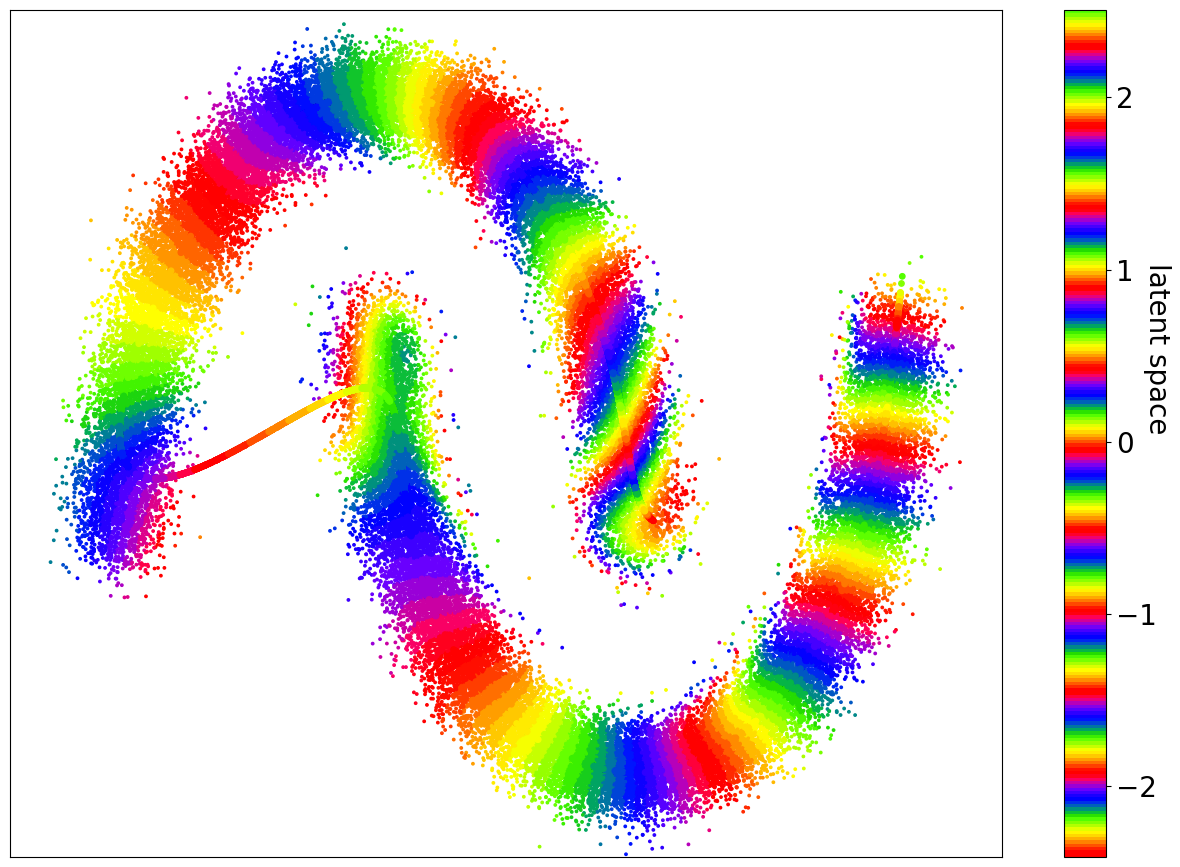

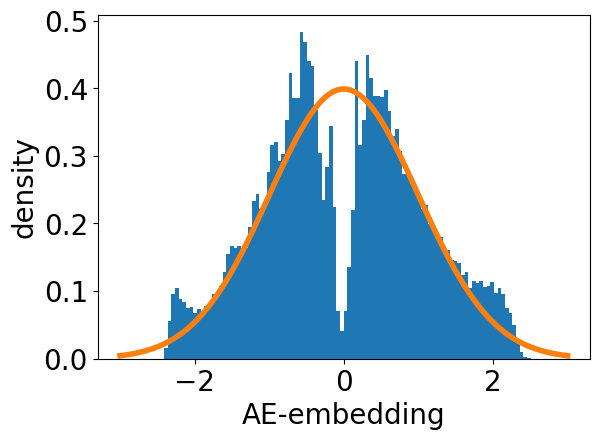

In [10]:
c_targets = plot_manifold(subject_model)

In [11]:
def save_data(rectangular_flow, name):
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    print("save data...")
    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    
    Path(f"data/{name}/subject_model").mkdir(parents=True, exist_ok=True)
    fileName = f"data/{name}/data"
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()
    shutil.copytree(sm_path, f"data/{name}/subject_model", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)

In [12]:
save_data(subject_model, name="2moons_demo1")

encoding traindata...
encoding valdata...
encoding testdata...
save data...


## Train fiber-learning model

In [13]:
data_name = "2moons_demo1"

In [14]:
hparams_fl_fif = fff.fif.FreeFormInjectiveFlowHParams(
    vae = True,
    noise = 0.01,
    data_set = {"name": "moons_split", "conditional": True, "path": data_name},
    loss_weights = {"nll": 1, "noisy_reconstruction": 10},
    train_models = True,
    models = [
        {"name": "fff.model.ResNet",
         "latent_dim": 1,
         "layers_spec": [
             [256,256],
             [256,256],
             [256,256]]}
    ],
    optimizer = {
        "name": "adam",
        "lr": 0.001,
    },
    lr_scheduler = "onecyclelr",
    max_epochs = 50,
    batch_size = 128,
    load_subject_model = True,
    accelerator = "gpu")

In [15]:
model = fff.fif.FreeFormInjectiveFlow(hparams_fl_fif)

cond_dim:  1
latent_dim:  1
loading subject_model
2moons
cond_dim:  0
latent_dim:  1


In [16]:
torch.set_grad_enabled(True)
model.fit(logger_kwargs=dict(name="fif_2m", save_dir="lightning_logs"))

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
INFO: 
  | Name          | Type                  | Params
--------------------------------------------------------
0 | models        | Sequential            | 405 K 
1 | subject_model | FreeFormInjectiveFlow | 268 K 
---------------------------------------

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/export/home/wjoran/FFF/fff/base.py:674: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = torch.mean(torch.abs(torch.std(z_details, dim=0) - 1))


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


{'training/z 1D-Wasserstein-1': 0.12512066960334778,
 'training/z std': 1.0717759132385254,
 'training/loss': 0.6774464845657349,
 'training/nll': 0.5505158305168152,
 'training/reconstruction': 0.012646375223994255,
 'training/noisy_reconstruction': 0.012693068012595177,
 'training/sqr_reconstruction': 0.0003163004876114428,
 'validation/z 1D-Wasserstein-1': 0.16646817326545715,
 'validation/z std': nan,
 'validation/loss': -3.1988236904144287,
 'validation/nll': -3.310662269592285,
 'validation/vol_change_encoder': 4.413358688354492,
 'validation/vol_change_decoder': 4.647911548614502,
 'validation/nll_encoder': -3.0761094093322754,
 'validation/nll_decoder': -3.310662269592285,
 'validation/reconstruction': 0.010572870261967182,
 'validation/noisy_reconstruction': 0.011183854192495346,
 'validation/sqr_reconstruction': 0.00020578448311425745,
 'validation/masked_reconstruction': 0.01118385512381792,
 'validation/z_reconstruction_encoder': 0.2003365308046341,
 'validation/fiber_loss'

## Evaluate fiber-learning model

In [27]:
#If you want to load a trained model
checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/2m1_fif_01_long", version=1, epoch="last")
model = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(checkpoint)

cond_dim:  1
latent_dim:  1
loading subject_model
2moons
cond_dim:  0
latent_dim:  1


processing data...
False
sampling fibers...
43.07772445678711
2.849367380142212
4.550961494445801
2.925671100616455
0.8978439569473267
2.0502538681030273
2.2371788024902344
1.6065895557403564
1.0407061576843262
0.8206769824028015
1.294974446296692
2.2883830070495605
118.56358337402344
11.228328704833984
1.6912119388580322
2.0111498832702637
1.8157751560211182
1.8146294355392456
1.1183488368988037
0.8822991847991943
2.109973430633545
0.73600172996521
1.8348110914230347
6.349147319793701
12.910256385803223
20.82119369506836
953.7025756835938
torch.Size([45900, 2])
torch.Size([45900, 2])
torch.Size([45900, 2])
torch.Size([45900, 2])


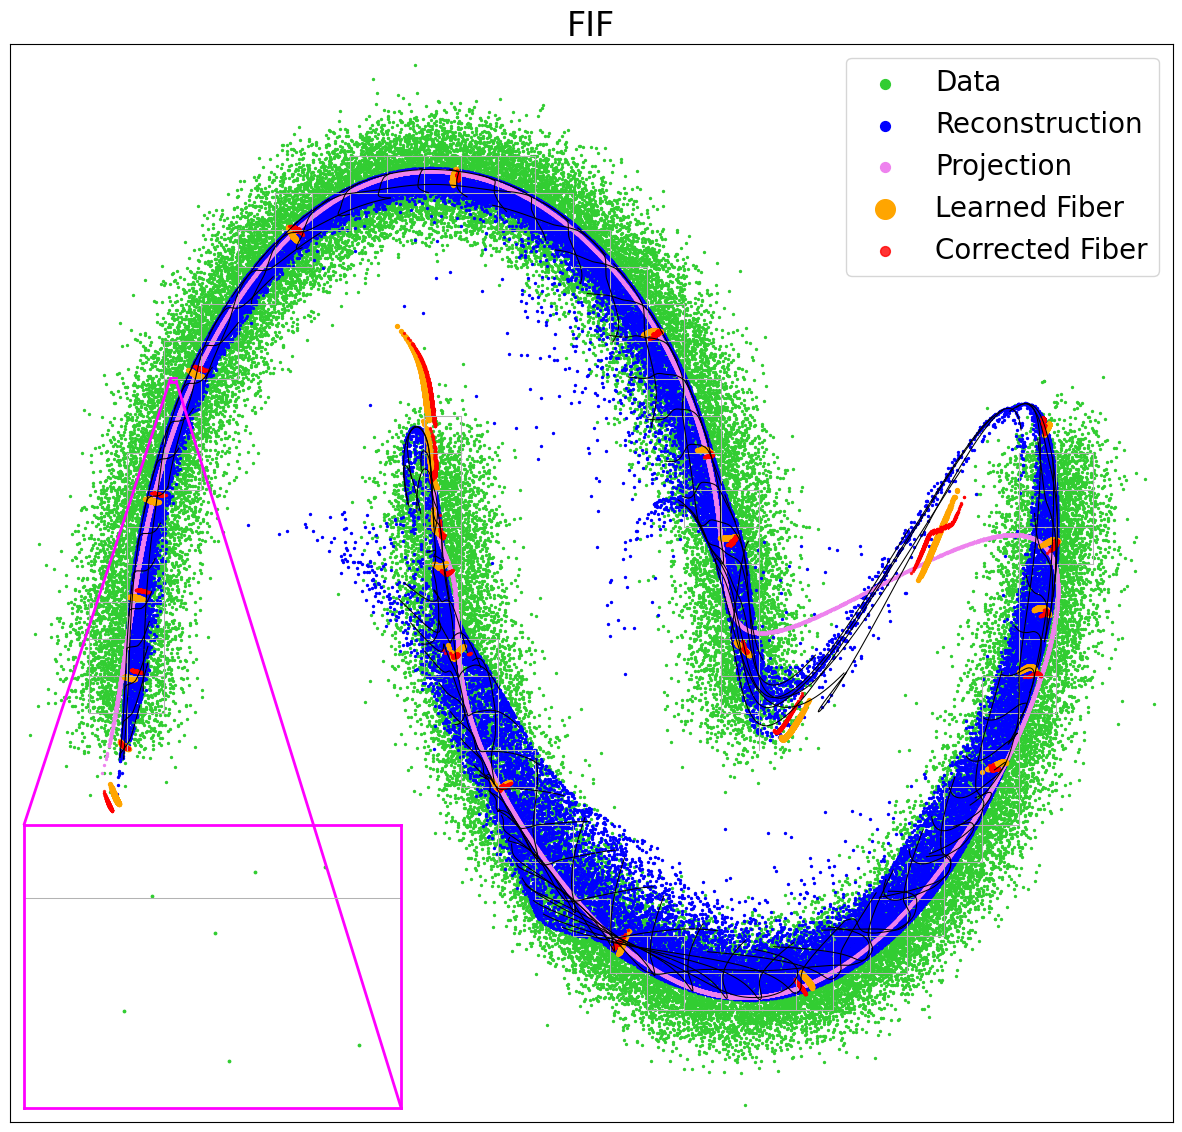

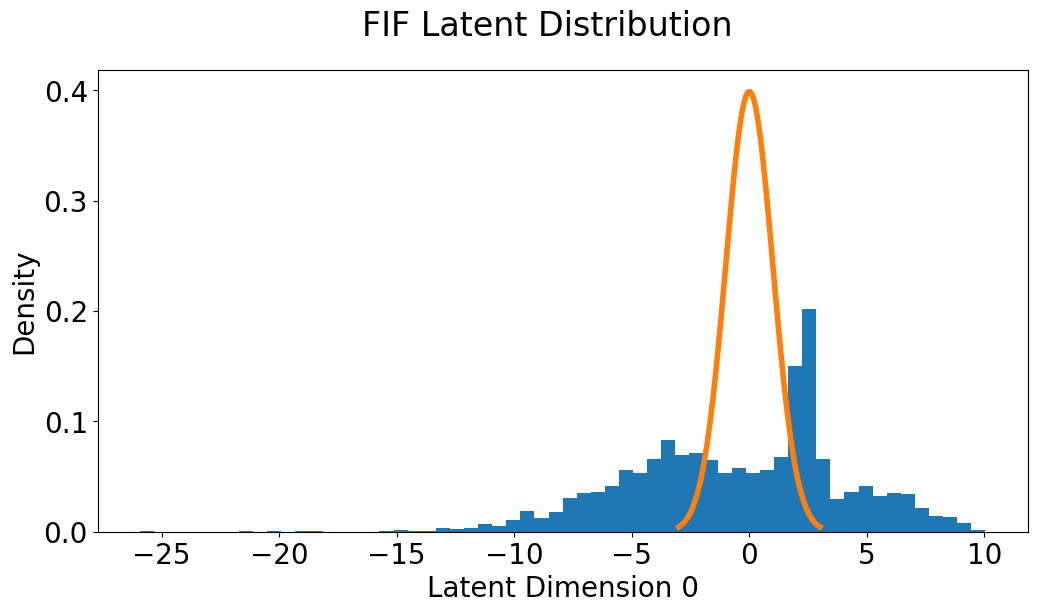

In [28]:
c_targets = plot_sm(model, data_type="train", gd_steps=5, N_fibers=27)

In [16]:
subject_model = model.subject_model
save = False
model_name = "FIF"

In [17]:
from fff.evaluate.plots import all_conditions

@torch.no_grad()
def plot_sm(model, data_type='train', gd_steps=50, N_fibers=21):
    device = subject_model.device
    fig, ax = plt.subplots(figsize=[15,14])
    data = {}

    if data_type=='train':
        data = subject_model.train_data[:]
    elif data_type=='val':
        data = subject_model.val_data[:]
    elif data_type=='test':
        data = subject_model.test_data[:]

    conditioned = subject_model.apply_conditions(data)
    samples = conditioned.x_noisy
    c_sm = conditioned.condition
    
    #plot samples
    plt_samples = samples.T.numpy()
    #col_sam = "green" if model.transform == "diffusion" else "limegreen"
    ax.scatter(*plt_samples, s=2, label=r"Data", c="limegreen" ,alpha=1)

    
    print("processing data...")
    batch_size = subject_model.hparams.batch_size
    z_sm = torch.cat([
        subject_model.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(samples.split(batch_size), c_sm.split(batch_size))
    ])
    #sm-model decodes data
    x1 = torch.cat([
        subject_model.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_sm.split(batch_size), c_sm.split(batch_size))
    ])   
    
    #reconstruct data with model
    model.to(device)
    c_m = (z_sm - model.data_shift) / model.data_scale
    print(model.transform)
    if model.transform != "diffusion":
        z_m = torch.cat([
            model.encode(batch.to(device), c_batch.to(device)).cpu()
            for batch, c_batch in zip(samples.split(batch_size), c_m.split(batch_size))
        ])
        if model.transform=="inn":
            z_list = []
            for batch, c_batch in zip(z_m.split(batch_size), c_m.split(batch_size)):
                _z_dense = model.transform_model.encode(batch.to(device), c_batch.to(device))
                while True:    
                    if isinstance(_z_dense, tuple):
                        _z_dense = _z_dense[0]
                    else: break
                z_list.append(_z_dense.detach().cpu())
            z_dense_m = torch.cat(z_list)
        elif model.transform:
            z_dense_m = torch.cat([
                model.transform_model.encode(batch.to(device), c_batch.to(device)).cpu()
                for batch, c_batch in zip(z_m.split(batch_size), c_m.split(batch_size))
            ])
        else:
            z_dense_m = z_m
    if model.transform not in ["diffusion", "inn"]:
        if model.transform:
            z1_m = torch.cat([
                model.transform_model.decode(batch.to(device), c_batch.to(device)).cpu()
                for batch, c_batch in zip(z_dense_m.split(batch_size), c_m.split(batch_size))
            ])
        else:
            z1_m = z_m
        x_m1 = torch.cat([
            model.decode(batch.to(device), c_batch.to(device)).cpu()
            for batch, c_batch in zip(z1_m.split(batch_size), c_m.split(batch_size))
        ])
    else:
         x_m1 = model.sample(torch.Size([x1.shape[0]]), c_m.to(device)).cpu()
                
    
    recon = x_m1.cpu().T.numpy()
    #plot reconstruction
    label_rec = "Samples" if model.transform in ["diffusion","inn"] else "Reconstruction"
    ax.scatter(*recon, s=2, label=label_rec, c='b',alpha=1)
    """
    lines_x = np.array([samples[0,:],recon[0,:]])
    lines_y = np.array([samples[1,:],recon[1,:]])
    plt.plot(lines_x, lines_y, linewidth=0.4, color='red', alpha=1)
    """        
    #plot decoded data
    ax.scatter(*x1.T, s=2, label=r"Projection", c="violet")
    
    print("sampling fibers...")
    fiber_size = 1000
    step = np.concatenate((np.linspace(-2.8,-0.4,N_fibers//3),np.linspace(-0.3,0.3,N_fibers//3),np.linspace(0.4,2.8,N_fibers//3)))
    c = []
    fibers_true = []
    for i in range(N_fibers):
        c.append(((torch.ones([fiber_size,1]) * step[i]) - model.data_shift) / model.data_scale)
    c = torch.cat(c)
    fibers_learned = model.sample(torch.Size([N_fibers*fiber_size]), c.to(device)).cpu()
    #correct fibers
    for i in range(N_fibers):
        x_c, _ = calc_PGD(fibers_learned[i*fiber_size:(i+1)*fiber_size], c[i*fiber_size:(i+1)*fiber_size], gd_steps)
        fibers_true.append(x_c)
    fibers_true = torch.cat(fibers_true)
    #plot both fibers
    ax.scatter(*fibers_learned.T, s=8, color = "orange", label="Learned Fiber")
    ax.scatter(*fibers_true.T, s=2, color = "red", label="Corrected Fiber",alpha=0.8)
    
    ax.axis('equal')
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    
    axins = zoomed_inset_axes(ax, 70, loc="lower left") # zoom = 6
    axins.spines['bottom'].set_color('magenta')
    axins.spines['bottom'].set_linewidth(2.)
    axins.spines['top'].set_color('magenta')
    axins.spines['top'].set_linewidth(2.)
    axins.spines['left'].set_color('magenta')
    axins.spines['left'].set_linewidth(2.)
    axins.spines['right'].set_color('magenta')
    axins.spines['right'].set_linewidth(2.)
    axins.scatter(*plt_samples, s=3, label=r"Data", c="limegreen" ,alpha=1)
    axins.scatter(*recon, s=3, label=label_rec, c='b',alpha=1)
    axins.scatter(*x1.T, s=3, label=r"Projection", c="violet")
    axins.scatter(*fibers_learned.T, s=3, color = "orange", label="Learned Fiber")
    axins.scatter(*fibers_true.T, s=3, color = "red", label="Corrected Fiber",alpha=0.8)
    
    # sub region of the original image
    x1, x2, y1, y2 = -1.56, -1.54, 0.7475, 0.7625
    #x1, x2, y1, y2 = -0.8, -0.4, 0.3, 0.8
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="magenta", linewidth=2)
    
    #plot grid reconstruction
    if not model.transform in ["diffusion", "inn"]:
        plot_samples_grid(ax, model)
        plot_samples_grid(axins, model)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    axins.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axins.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    ax.legend(markerscale=5., loc="upper right")
    ax.set_title(f"{model_name}")
    if save:
        path = f"plots/{plot_dir}/eval_plot.png"
        plt.savefig(path, bbox_inches='tight')
    plt.show()
    plt.close()

    
    #plot latent distribution
    if not model.transform == "diffusion":
        n_dim = z_dense_m.shape[1]
        fig, axes = plt.subplots(1, n_dim, figsize=(12*n_dim, 6))
        a = np.linspace(-3,3,100)
        for i in range(n_dim):
            if n_dim>1:
                axis = axes[i]
            else:
                axis = axes
            axis.hist(z_dense_m[:4000,i].squeeze(), bins=60, density=True)
            axis.plot(a, normal(a), linewidth=4)
            axis.set_xlabel(f'Latent Dimension {i}')
            axis.set_ylabel('Density')
        fig.suptitle(f'{model_name} Latent Distribution')
        if save:
            path = f"plots/{plot_dir}/latent.png"
            plt.savefig(path, bbox_inches='tight')

In [18]:
from fff.evaluate.plots import ensure_list, build_mesh
@torch.no_grad()

def plot_grid(ax, mapping, pos_min, pos_max, resolution=25,
              sub_resolution=0, color="black", linewidth=0.75, linestyle="-",
              pos_in_filter=None, device=None, dtype=None, **kwargs):
    for row_mode, this_resolution in zip([True, False],
                                         ensure_list(resolution, 2)):
        lines_resolution = [this_resolution,
                            this_resolution * (sub_resolution + 1)][::-1 if row_mode else 1]
        x, y, pos = build_mesh(pos_min, pos_max, lines_resolution,
                               device=device, dtype=dtype)
        if pos_in_filter is not None:
            pos[~pos_in_filter(pos)] = float("nan")
        pos_out = mapping(pos).cpu()
        pos_new = pos_out.reshape((*x.shape, -1)).numpy()
        if row_mode:
            segs = pos_new.transpose(1, 0, 2)
        else:
            segs = pos_new
        ax.plot(segs[:, :, 0], segs[:, :, 1], ls=linestyle, color=color,
                 lw=linewidth, **kwargs)

@torch.no_grad()
def plot_samples_grid(ax, model, resolution=30):
    extent = [-2, 2]
    def reconstruction(x):
        x = x.to(subject_model.device)
        print(x.shape)
        c_sm = subject_model.apply_conditions((x,)).condition
        c = (subject_model.encode(x, c_sm) - model.data_shift) / model.data_scale
        return model(x,c)
    
    def distance_filter(pos):
        dist = torch.min(((pos.unsqueeze(0) - model.val_data[:][0].unsqueeze(1))**2).sum(dim=2), dim=0)[0]
        return dist < 0.03
    
    plot_grid(ax, lambda x: x, *extent, color="0.7", resolution=resolution, pos_in_filter=distance_filter)
    plot_grid(ax, reconstruction, *extent, sub_resolution=50, resolution=resolution, pos_in_filter=distance_filter)

In [19]:
def calc_PGD(x, c0, n_steps):
    torch.set_grad_enabled(True)
    c0 = torch.unsqueeze(c0,dim=0)
    x = x.to(model.device)
    
    def closs(c0, c_hat, x_hat):
        v = torch.sum(torch.sqrt(torch.sum(((c0 - c_hat)**2), dim=-1)))
        return v
    
    class XModel(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.param = torch.nn.Parameter(x.clone())
    
    xmodel = XModel()
    optimizer = torch.optim.Adam(xmodel.parameters(), lr=0.005)
    max_x = torch.max(torch.abs(xmodel.param))
    
    c_empty = torch.empty((0,), device=model.device, dtype=x.dtype)
    for i in range(n_steps):
        conditioned = subject_model.apply_conditions((xmodel.param.to(model.device),))
        c_sm = conditioned.condition
        x_sm = conditioned.x0
        xc = (subject_model.encode(x_sm, c_sm).cpu() - model.data_shift) / model.data_scale
        loss = closs(c0, xc, x)
        """
        if loss < 1:
            for g in optimizer.param_groups:
                g['lr'] = 0.001
        """
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (loss<0.01 or math.isnan(loss)):
            break

    
    
    torch.set_grad_enabled(False)
    max_x_after = torch.max(torch.abs(xmodel.param))
    if max_x_after > 5. and (max_x_after-max_x) > 1.:
        print("warning!, z got an extreme value:", max_x_after)
    x = xmodel.param.detach().cpu()
    print(loss.item())
    return x, loss